# bag of holding (aka. making neural networks smaller)

## setup

In [76]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm
from datetime import datetime

device = 'cuda' if t.cuda.is_available() else 'cpu'

In [58]:
batch_size = 640

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
def imshow(img):
    if img.shape[0] == 1: img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

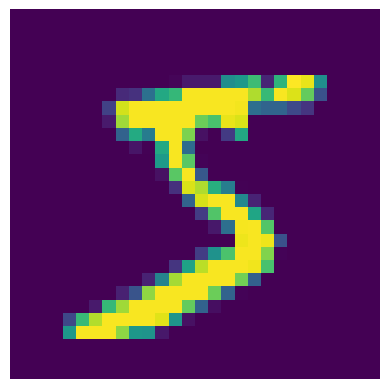

In [26]:
imshow(train_dataset[0][0])

In [77]:
class Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(784, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 10),
            # nn.Linear(784, 32),
            # nn.LeakyReLU(),
            # nn.Linear(32, 32),
            # nn.LeakyReLU(),
            # nn.Linear(32, 10),
        )

    def forward(self, x):
        return self.mlp(x.flatten(start_dim=-3))

In [78]:
@t.no_grad()
def eval(model, dataloader=test_loader):
    model.eval()
    loss, accuracy, count = 0, 0, 0
    for x, y in dataloader:
        logits = model(x.to(device))
        loss += F.cross_entropy(logits, y.to(device)).item()
        accuracy += (logits.argmax(1) == y.to(device)).sum().item()
        count += len(x)
    model.train()
    return loss / count, accuracy / count

def eval_dict(model, dataloader=test_loader, name='test'):
    loss, accuracy = eval(model, dataloader=dataloader)
    return {f'{name}_loss': loss, f'{name}_accuracy': accuracy}

# eval_dict(mnist)

In [79]:
def train(model, opt, dataloader=train_loader, wnb=True, epochs=1000):
    model.train()
    if wnb: wandb.init()
    for epoch in tqdm(range(epochs)):
        for x, y in dataloader:
            logits = model(x.to(device))
            loss = F.cross_entropy(logits, y.to(device))
            opt.zero_grad()
            loss.backward()
            opt.step()
        if epoch % 10 == 0 or epoch == epochs - 1:
            if wnb: wandb.log({'epoch': epoch} | eval_dict(model) | eval_dict(model, dataloader=train_loader, name='train'))
    if wnb: wandb.finish()

In [80]:
mnist = Mnist().to(device)
opt = optim.AdamW(mnist.parameters(), lr=3e-4)
train(mnist, opt, epochs=100)

100%|██████████| 100/100 [08:07<00:00,  4.88s/it]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▂▂▃▄▅▅▆▇▇█
test_accuracy,▁▆▇████████
test_loss,█▂▁▁▁▁▁▁▁▁▁
train_accuracy,▁▆▇▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁▁
epoch,99
test_accuracy,0.9792
test_loss,0.00016
train_accuracy,0.99992
train_loss,0.0


In [82]:
t.save(mnist.state_dict(), f'weights/mnist-128-64-10_{datetime.now().strftime("%Y-%m-%d_%Hh%M")}.pt')

## quantization

In [259]:
def quantize(weights, bits=8):
    maxi = weights.max()
    mini = weights.min()
    qmaxi = 2 ** bits - 1
    scale = (maxi - mini) / qmaxi
    zero = int(t.round(-mini / scale))
    quantized_weights = t.clamp(t.round(weights / scale) + zero, 0, qmaxi)
    return quantized_weights, scale, zero

def unquantize(quantized_weights, scale, zero):
    return (quantized_weights - zero) * scale

In [260]:
def test_bounds(weights, bits=8):
    qw, _, _ = quantize(weights, bits=bits)
    assert qw.min() == 0
    assert qw.max() == 2**bits - 1

def test_round_trip(weights, bits=8, threshold=0.02):
    ''' this is flaky at best '''
    qw, scale, zero = quantize(weights, bits=bits)
    w = unquantize(qw, scale, zero)
    assert weights.allclose(w, atol=threshold), f'{(weights - w).abs().max()=}'

def test_more_bits_do_better(weights):
    ''' flaky too '''
    def encode_decode_max_abs_error(bits):
        qw, scale, zero = quantize(weights, bits=bits)
        w = unquantize(qw, scale, zero)
        return (weights - w).abs().max()
    error1 = encode_decode_max_abs_error(bits=4)
    error2 = encode_decode_max_abs_error(bits=8)
    error3 = encode_decode_max_abs_error(bits=16)
    assert error1 > error2 > error3, f'{error1=}, {error2=}, {error3=}'

for _ in range(100):
    xs = t.randn(100, 100)
    test_bounds(xs)
    test_round_trip(xs)
    test_more_bits_do_better(xs)

In [261]:
def quantization_stats(weights):
    qw, scale, zero = quantize(weights, bits=8)
    w = unquantize(qw, scale, zero)
    print(f'mean: {weights.mean()} {w.mean()}')
    print(f'max: {weights.max()} {w.max()}')
    print(f'min: {weights.min()} {w.min()}')
    print(f'atol: {(weights - w).abs().max()}')

xs = t.rand(10000)
quantization_stats(xs)

mean: 0.49599745869636536 0.4960039556026459
max: 0.9999246001243591 0.9997732639312744
min: 0.0001513957977294922 0.0
atol: 0.001960158348083496
